# Plotting Empty Set Dollar(ESD) Epoch Bonding Data

We look at how ESD unlocked amounts trend with upcoming epochs

Import dependencies:

In [76]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import requests
from datetime import datetime, timezone

Define the epoch start, period and offsets:

In [77]:
epoch_period = 28800
epoch_start = 1602201600
epoch_offset = 105

Next, we define some key global variables to use with the Covalent APIs:

In [78]:
API_KEY = 'u473736hfdf-347yfd-fdu34hg'

starting_block = 1

topic_address = '0x93530ac0ee8c50e696e13c5ac62355d0c0ba4bd943620d5bda1eb08b64ae7512'

pool_sender_address = '0x4082D11E506e3250009A991061ACd2176077C88f'

dao_sender_address = '0x443D2f2755DB5942601fa062Cc248aAA153313D3'

Function for retrieving the latest block number:

In [79]:
def get_latest_block_num():
  covalent_block_api = 'https://api.covalenthq.com/v1/1/block_v2/latest'

  payload = {
      "key": API_KEY,
      "page-size": 9999
  }

  block_request = requests.get(covalent_block_api, params=payload)
  latest_block_number = block_request.json()['data']['items'][0]['height']
  return(latest_block_number)




Function for getting the unbonded events for both the POOL and DAO:

In [111]:
def get_unbonded_events(lockup_epochs, type):
    
    latest_block = get_latest_block_num()
    
    covalent_topic_api = f'https://api.covalenthq.com/v1/1/events/topics/{topic_address}/'

    sender_address = pool_sender_address if type == 'POOL' else dao_sender_address

    payload = {
        "starting-block": starting_block,
        "ending-block": latest_block,
        "sender-address": sender_address,
        "key": API_KEY,
        "page-size": 9999
    }

    r = requests.get(covalent_topic_api, params=payload)
    data = r.json()
    
    # Filter out the json data
    filtered_data = []

    for item in data["data"]["items"]:
        epoch_block = int(item["decoded"]["params"][1]["value"])
        endtimestamp = datetime.fromtimestamp(
                (epoch_start + (epoch_period * (epoch_block - epoch_offset)) + epoch_period * lockup_epochs), timezone.utc
                ).strftime('%Y-%m-%d %H:%M')

        filtered_data.append({
            "address": item["decoded"]["params"][0]["value"],
            "startEpoch": epoch_block,
            "endTimestamp": endtimestamp,
            "amount": int(item["decoded"]["params"][2]["value"]) / 1e18,
            "type": type
        })

    return(filtered_data)

Function for writing a list of dictionaries to a CSV given the data and headers:

In [112]:
def write_csv(data, filename, headers):
  with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()

        for item in data:
            writer.writerow(item)
            
        print('Data written to CSV')


Now the `main` function which calls for all the events:

In [113]:
def main():
    now_utc = datetime.utcnow().strftime('%Y-%m-%d %H:%M')

    # Get unbonded events for next POOL lockup epochs:
    pool_unbond_evt_items = get_unbonded_events(4,'POOL')

    # Filter pool unbond events by those in the future from this point
    filtered_pool_evts = [d for d in pool_unbond_evt_items if d['endTimestamp'] >= now_utc]

    # Get unbonded events for next DAO lockup epochs:
    dao_unbond_evt_items = get_unbonded_events(14, 'DAO')

    # Filter dao unbond events by those in the future from this point
    filtered_dao_evts = [d for d in dao_unbond_evt_items if d['endTimestamp'] >= now_utc]

    # Combine events and reverse sort by endTimestamp
    combined_evts = sorted(filtered_pool_evts + filtered_dao_evts, key = lambda i: i['endTimestamp'])

    # Write data to CSV
    csv_headers = ['address', 'startEpoch', 'endTimestamp', 'amount', 'type']
    write_csv(combined_evts, 'data.csv', csv_headers)


main()

Data written to CSV


The above function generates the `data.csv`. The next few steps create a bar chart using that data. 

## Bar Plots

First we import the data as a dataframe. 

In [114]:
df = pd.read_csv('data.csv')

Next, we filter out the data frame by `type` and plot the `'POOL'` and `'DAO'` data separately:

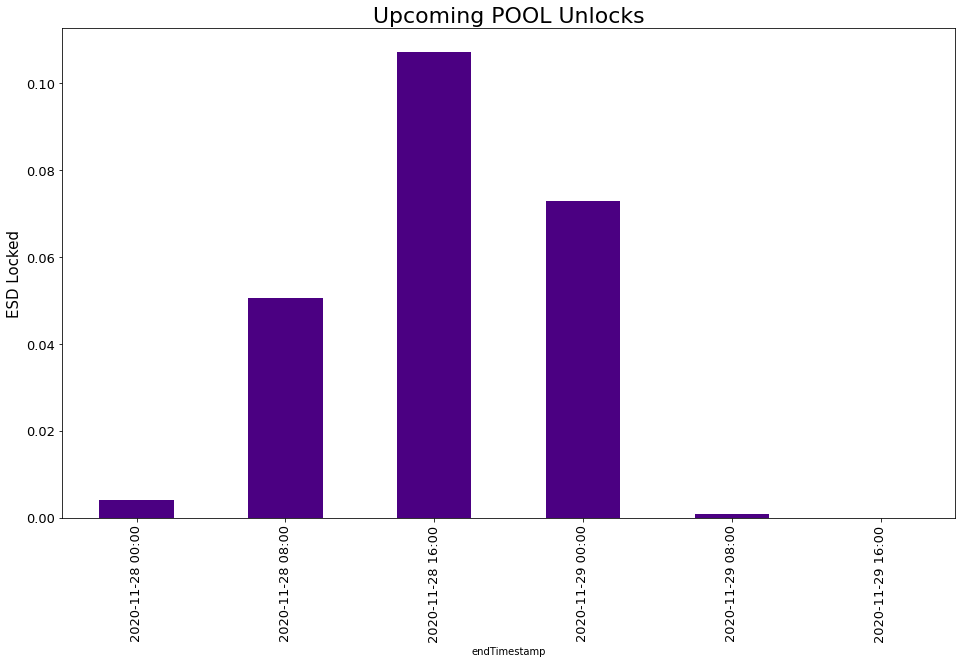

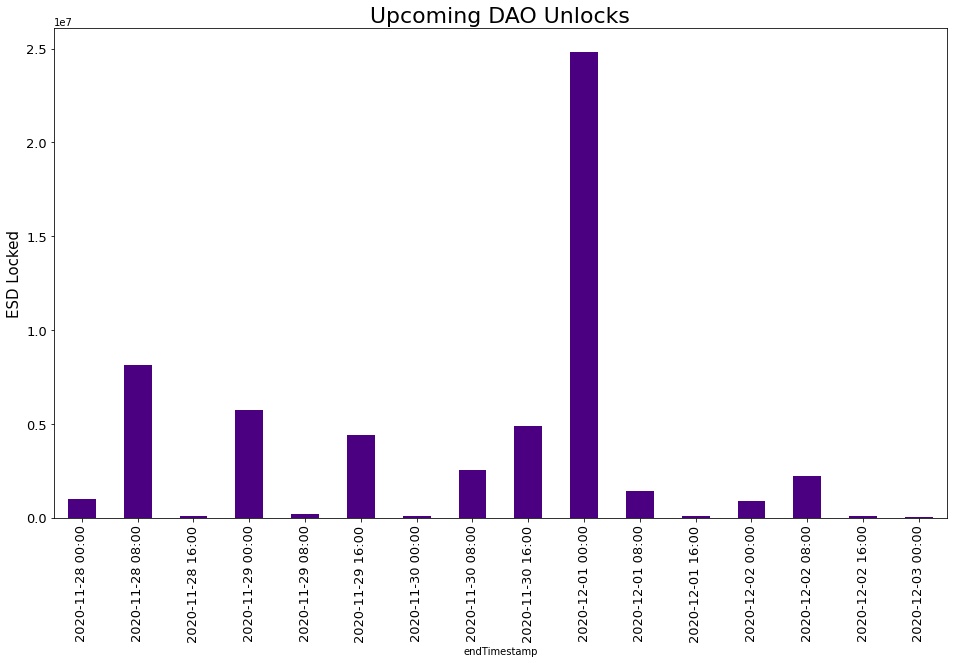

In [115]:
pool_df = df[df['type'] == 'POOL']
dao_df = df[df['type'] == 'DAO']

pool_df = pool_df.groupby('endTimestamp')['amount'].sum()
dao_df = dao_df.groupby('endTimestamp')['amount'].sum()

fig, ax1 = plt.subplots(figsize=(16,9))

ax1 = pool_df.plot(kind='bar', color="indigo", fontsize=13)
ax1.set_title("Upcoming POOL Unlocks", fontsize=22)
ax1.set_ylabel("ESD Locked", fontsize=15)


fig, ax2 = plt.subplots(figsize=(16,9))
ax2 = dao_df.plot(kind='bar', color="indigo", fontsize=13)
ax2.set_title("Upcoming DAO Unlocks", fontsize=22)
ax2.set_ylabel("ESD Locked", fontsize=15)

plt.show()